# testing_cbpnet

The point of this file is to test chrombpnet to make sure that we understand how it works

The first step is the inputs and outputs of the model. We will create a fake args so we can easily put it into the various functions

In [1]:
import argparse
import sys
sys.path.append('/data/leslie/sarthak/chrombpnet/')
sys.path.append('/data/leslie/sarthak/chrombpnet/utils/')
from utils.test_args import main
sys.argv = [
    'test_args.py', 'pipeline',
    '-ibam', 'merged.bam',
    '-d', 'ATAC',
    '-g', 'hg38.fa',
    '-c', 'hg38.chrom.sizes',
    '-p', 'peaks_no_blacklist.bed',
    '-n', 'output_negatives.bed',
    '-fl', 'splits/fold_0.json',
    '-b', 'bias_model/models/k562_bias.h5',
    '-o', 'chrombpnet_model/'
]
args = main()
#and now we can simulate our args


Namespace(cmd='pipeline', genome='hg38.fa', chrom_sizes='hg38.chrom.sizes', input_bam_file='merged.bam', input_fragment_file=None, input_tagalign_file=None, output_dir='chrombpnet_model/', data_type='ATAC', peaks='peaks_no_blacklist.bed', nonpeaks='output_negatives.bed', chr_fold_path='splits/fold_0.json', outlier_threshold=0.9999, ATAC_ref_path=None, DNASE_ref_path=None, num_samples=10000, inputlen=2114, outputlen=1000, seed=1234, epochs=50, early_stop=5, learning_rate=0.001, trackables=['logcount_predictions_loss', 'loss', 'logits_profile_predictions_loss', 'val_logcount_predictions_loss', 'val_loss', 'val_logits_profile_predictions_loss'], architecture_from_file=None, file_prefix=None, html_prefix='./', bsort=False, tmpdir=None, no_st=False, bias_model_path='bias_model/models/k562_bias.h5', negative_sampling_ratio=0.1, filters=512, n_dilation_layers=8, max_jitter=500, batch_size=64)


In [2]:
#now we modify args
import json
import os
if args.file_prefix:
    fpx = args.file_prefix+"_"
else:
    fpx = ""
    
# Shift bam and convert to bigwig
# import chrombpnet.helpers.preprocessing.reads_to_bigwig as reads_to_bigwig	
args.output_prefix = os.path.join(args.output_dir,"auxiliary/{}data".format(fpx))
args.plus_shift = None
args.minus_shift = None
args.bigwig = os.path.join(args.output_dir,"auxiliary/{}data_unstranded.bw".format(fpx))
args.output_prefix = os.path.join(args.output_dir,"evaluation/{}bw_shift_qc".format(fpx))
os.chdir('/data/leslie/sarthak/data/chrombpnet_test/')
folds = json.load(open(args.chr_fold_path))
assert(len(folds["valid"]) > 0) # validation list of chromosomes is empty
args.chr = folds["valid"][0]
args.pwm_width=24
folds

{'test': ['chr11', 'chr12'],
 'valid': ['chr8', 'chr10'],
 'train': ['chr1',
  'chr2',
  'chr3',
  'chr4',
  'chr5',
  'chr6',
  'chr7',
  'chr9',
  'chr13',
  'chr14',
  'chr15',
  'chr16',
  'chr17',
  'chr18',
  'chr19',
  'chr20',
  'chr21',
  'chr22',
  'chrX',
  'chrY']}

In [3]:
import copy
import chrombpnet.training.models.chrombpnet_with_bias_model as chrombpnet_with_bias_model
import chrombpnet.training.train as train
args_copy = copy.deepcopy(args)
if args_copy.architecture_from_file is None:
    args_copy.architecture_from_file = 	chrombpnet_with_bias_model.__file__
args_copy.peaks = os.path.join(args.output_dir,"auxiliary/{}filtered.peaks.bed".format(fpx))
args_copy.nonpeaks = os.path.join(args.output_dir,"auxiliary/{}filtered.nonpeaks.bed".format(fpx))
args_copy.output_prefix = os.path.join(args.output_dir,"models/{}chrombpnet".format(fpx))
args_copy.params = os.path.join(args.output_dir,"logs/{}chrombpnet_model_params.tsv".format(fpx))

In [4]:
args_copy #this is the official one that has all of the things specified!

Namespace(cmd='pipeline', genome='hg38.fa', chrom_sizes='hg38.chrom.sizes', input_bam_file='merged.bam', input_fragment_file=None, input_tagalign_file=None, output_dir='chrombpnet_model/', data_type='ATAC', peaks='chrombpnet_model/auxiliary/filtered.peaks.bed', nonpeaks='chrombpnet_model/auxiliary/filtered.nonpeaks.bed', chr_fold_path='splits/fold_0.json', outlier_threshold=0.9999, ATAC_ref_path=None, DNASE_ref_path=None, num_samples=10000, inputlen=2114, outputlen=1000, seed=1234, epochs=50, early_stop=5, learning_rate=0.001, trackables=['logcount_predictions_loss', 'loss', 'logits_profile_predictions_loss', 'val_logcount_predictions_loss', 'val_loss', 'val_logits_profile_predictions_loss'], architecture_from_file='/data/leslie/sarthak/environments/chrombpnet/lib/python3.10/site-packages/chrombpnet/training/models/chrombpnet_with_bias_model.py', file_prefix=None, html_prefix='./', bsort=False, tmpdir=None, no_st=False, bias_model_path='bias_model/models/k562_bias.h5', negative_samplin

In [5]:
args = args_copy

In [6]:
#but instead of directly calling train.main, we'll go through it to get to the source of our things!
import numpy as np
import chrombpnet.training.data_generators.initializers as initializers
parameters = train.get_model_param_dict(args)
print(parameters)
np.random.seed(args.seed)

# get model architecture to load
# model, architecture_module=train.get_model(args, parameters)

# initialize generators to load data
# train_generator = initializers.initialize_generators(args, "train", parameters, return_coords=False) #gets the peaks and takes forever to get the sequences
# valid_generator = initializers.initialize_generators(args, "valid", parameters, return_coords=False)

{'counts_loss_weight': '76.2', 'filters': '512', 'n_dil_layers': '8', 'bias_model_path': 'chrombpnet_model/models/bias_model_scaled.h5', 'inputlen': '2114', 'outputlen': '1000', 'max_jitter': '500', 'chr_fold_path': 'splits/fold_0.json', 'negative_sampling_ratio': '0.1'}


In [7]:
model, architecture_module=train.get_model(args, parameters) #this is killing it for some reason if we use the lt nodes...

: 

: 

: 

In [ ]:
model.summary()
#it seems model is what is considered the bias as they both take in sequence separately

'''
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 sequence (InputLayer)          [(None, 2114, 4)]    0           []                               
                                                                                                  
 model_wo_bias (Functional)     [(None, 1000),       6377986     ['sequence[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 model (Functional)             [(None, 1000),       217730      ['sequence[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['model_wo_bias[0][1]',          
                                                                  'model[0][1]']                  
                                                                                                  
 logits_profile_predictions (Ad  (None, 1000)        0           ['model_wo_bias[0][0]',          
 d)                                                               'model[0][0]']                  
                                                                                                  
 logcount_predictions (Lambda)  (None, 1)            0           ['concatenate[0][0]']            
                                                                                                  
==================================================================================================
Total params: 6,595,716
Trainable params: 6,377,986
Non-trainable params: 217,730
__________________________________________________________________________________________________
'''

#model architecture can be found here
#/data/leslie/sarthak/data/chrombpnet_test/model_architecture.png
#/data/leslie/sarthak/chrombpnet/model_architecture.png

NameError: name 'model' is not defined

In [ ]:
#the bias model itself can be found using
'''
submodel_layer = model.get_layer('model')
submodel_layer.summary()
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 sequence (InputLayer)          [(None, 2114, 4)]    0           []                               
                                                                                                  
 bpnet_1st_conv (Conv1D)        (None, 2094, 128)    10880       ['sequence[0][0]']               
                                                                                                  
 bpnet_1conv (Conv1D)           (None, 2090, 128)    49280       ['bpnet_1st_conv[0][0]']         
                                                                                                  
 bpnet_1crop (Cropping1D)       (None, 2090, 128)    0           ['bpnet_1st_conv[0][0]']         
                                                                                                  
 add (Add)                      (None, 2090, 128)    0           ['bpnet_1conv[0][0]',            
                                                                  'bpnet_1crop[0][0]']            
                                                                                                  
 bpnet_2conv (Conv1D)           (None, 2082, 128)    49280       ['add[0][0]']                    
                                                                                                  
 bpnet_2crop (Cropping1D)       (None, 2082, 128)    0           ['add[0][0]']                    
                                                                                                  
 add_1 (Add)                    (None, 2082, 128)    0           ['bpnet_2conv[0][0]',            
                                                                  'bpnet_2crop[0][0]']            
                                                                                                  
 bpnet_3conv (Conv1D)           (None, 2066, 128)    49280       ['add_1[0][0]']                  
                                                                                                  
 bpnet_3crop (Cropping1D)       (None, 2066, 128)    0           ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 2066, 128)    0           ['bpnet_3conv[0][0]',            
                                                                  'bpnet_3crop[0][0]']            
                                                                                                  
 bpnet_4conv (Conv1D)           (None, 2034, 128)    49280       ['add_2[0][0]']                  
                                                                                                  
 bpnet_4crop (Cropping1D)       (None, 2034, 128)    0           ['add_2[0][0]']                  
                                                                                                  
 add_3 (Add)                    (None, 2034, 128)    0           ['bpnet_4conv[0][0]',            
                                                                  'bpnet_4crop[0][0]']            
                                                                                                  
 prof_out_precrop (Conv1D)      (None, 1960, 1)      9601        ['add_3[0][0]']                  
                                                                                                  
 logits_profile_predictions_pre  (None, 1000, 1)     0           ['prof_out_precrop[0][0]']       
 flatten (Cropping1D)                                                                             
                                                                                                  
 gap (GlobalAveragePooling1D)   (None, 128)          0           ['add_3[0][0]']                  
                                                                                                  
 logits_profile_predictions (Fl  (None, 1000)        0           ['logits_profile_predictions_pref
 atten)                                                          latten[0][0]']                   
                                                                                                  
 logcount_predictions (Dense)   (None, 1)            129         ['gap[0][0]']                    
                                                                                                  
==================================================================================================
Total params: 217,730
Trainable params: 0
Non-trainable params: 217,730
__________________________________________________________________________________________________
'''

#now running submodel_layer(input) gives us the output, which is indeed 2x1000 as the summaryshows
#but now we know how to access sub parts of the model to like see what these convolutions are doing! It's very basic tho

In [38]:
#nowlet's manualy go through the data loading process!
#for now let's set some basic variables
import pandas as pd
mode = "train"
return_coords = False
peak_regions=None
nonpeak_regions=None
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
splits_dict=json.load(open(args.chr_fold_path))

if args.peaks.lower() != "none":
    print("loading peaks...")
    peak_regions=pd.read_csv(args.peaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
    peak_regions, chroms=initializers.get_bed_regions_for_fold_split(peak_regions, mode, splits_dict)

if args.nonpeaks.lower() != "none":
    print("loading nonpeaks...")
    nonpeak_regions=pd.read_csv(args.nonpeaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
    nonpeak_regions, chroms=initializers.get_bed_regions_for_fold_split(nonpeak_regions, mode, splits_dict) 

#this is quite quick, again it's just the number of peaks and nonpeaks that are loaded

loading peaks...
got split:train for bed regions:(220311, 10)
loading nonpeaks...
got split:train for bed regions:(220221, 10)


In [31]:
peak_regions.head() #it's exactly what we expect, shows the start and end and the peak name

,chr,start,end,1,2,3,4,5,6,summit
0,chr1,100027916,100029541,Peak_168774,375,.,3.46597,37.52287,35.56670,1291
1,chr1,100027916,100029541,Peak_212397,247,.,2.93255,24.75966,22.90134,89
2,chr1,100027916,100029541,Peak_231027,212,.,2.75187,21.27480,19.45153,688
3,chr1,100027916,100029541,Peak_240800,198,.,2.67162,19.80458,17.99839,479
4,chr1,100027916,100029541,Peak_64424,1000,.,8.38628,201.28123,198.87112,1078


In [39]:
inputlen, outputlen, \
nonpeak_regions, negative_sampling_ratio, \
max_jitter, add_revcomp, shuffle_at_epoch_start  =  initializers.fetch_data_and_model_params_based_on_mode(mode, args, parameters, nonpeak_regions, peak_regions)

In [34]:
print(f'inputlen: {inputlen}', f'outputlen: {outputlen}', f'negative_sampling_ratio: {negative_sampling_ratio}', f'max_jitter: {max_jitter}', f'add_revcomp: {add_revcomp}', f'shuffle_at_epoch_start: {shuffle_at_epoch_start}', sep='\n')
#all of this is quite obvious, so this negative sampling ratio means it samples 10% of the data to be negative
#all of this is again quite obvious!


inputlen: 2114
outputlen: 1000
negative_sampling_ratio: 0.1
max_jitter: 500
add_revcomp: True
shuffle_at_epoch_start: True


In [40]:
#now the next part is input into the Batch generator, this is the annoying part that takes a while

peak_regions=peak_regions
nonpeak_regions=nonpeak_regions
genome_fasta=args.genome
batch_size=args.batch_size
inputlen=inputlen                                
outputlen=outputlen
max_jitter=max_jitter
negative_sampling_ratio=negative_sampling_ratio
cts_bw_file=args.bigwig
add_revcomp=add_revcomp
return_coords=return_coords
shuffle_at_epoch_start=shuffle_at_epoch_start

In [41]:
from chrombpnet.training.utils import data_utils
peak_seqs, peak_cts, peak_coords, nonpeak_seqs, nonpeak_cts, nonpeak_coords, = data_utils.load_data(peak_regions, nonpeak_regions, genome_fasta, cts_bw_file, inputlen, outputlen, max_jitter)
#this is definitely the long part...
#i mean it makes sense if it's trying to load all the sequences?
#it's taking over 5 minutes? now 8. 
#it's very basic, just finds the start and stop and uses the summit from bigwig and fasta files
#this is only for train though, so maybe it will be faster?
#yes 20 minutes!


In [51]:
print(peak_seqs.shape, peak_seqs) #one hot encoded
#wait why 3114? so that we can jitter up to 500 in either direction?
#that's exactly it

(220311, 3114, 4) [[[1 0 0 0]
  [0 1 0 0]
  [0 0 0 1]
  ...
  [1 0 0 0]
  [1 0 0 0]
  [0 0 1 0]]

 [[0 1 0 0]
  [0 0 0 1]
  [0 0 1 0]
  ...
  [1 0 0 0]
  [0 0 1 0]
  [0 1 0 0]]

 [[0 1 0 0]
  [0 0 0 1]
  [0 1 0 0]
  ...
  [1 0 0 0]
  [0 0 0 1]
  [0 0 1 0]]

 ...

 [[0 1 0 0]
  [0 0 0 1]
  [0 1 0 0]
  ...
  [0 1 0 0]
  [0 1 0 0]
  [1 0 0 0]]

 [[0 0 0 1]
  [0 0 1 0]
  [0 0 1 0]
  ...
  [0 0 1 0]
  [0 0 1 0]
  [0 0 0 1]]

 [[0 0 0 1]
  [1 0 0 0]
  [1 0 0 0]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [1 0 0 0]]]


In [45]:
peak_cts.shape #the counts?

(220311, 2000)

In [48]:
print(peak_coords.shape, peak_coords) #idk what this 'f' and '1' are. f is just f, 1 is bool if it's a peak or not
#of course in the peaks it should all be, in the nonopeaks none of it should be

(220311, 4) [['chr1' '100029207' 'f' '1']
 ['chr1' '100028005' 'f' '1']
 ['chr1' '100028604' 'f' '1']
 ...
 ['chrY' '12395195' 'f' '1']
 ['chrY' '18992931' 'f' '1']
 ['chrY' '4030923' 'f' '1']]


In [50]:
print(nonpeak_coords.shape, nonpeak_coords) #same as above
#unsure why there's 100 less but there are

(220221, 4) [['chr14' '91539057' 'f' '0']
 ['chr4' '35755057' 'f' '0']
 ['chr19' '21845057' 'f' '0']
 ...
 ['chr9' '121258057' 'f' '0']
 ['chr3' '177739057' 'f' '0']
 ['chr2' '219023057' 'f' '0']]


In [49]:
#let's save all 6 numpy arrays to this folder
folder = '/data/leslie/sarthak/data/chrombpnet_test/saved_data/'
#now save them with numpy.save
np.save(folder+'peak_seqs.npy', peak_seqs)
np.save(folder+'peak_cts.npy', peak_cts)
np.save(folder+'peak_coords.npy', peak_coords)
np.save(folder+'nonpeak_seqs.npy', nonpeak_seqs)
np.save(folder+'nonpeak_cts.npy', nonpeak_cts)
np.save(folder+'nonpeak_coords.npy', nonpeak_coords)

In [ ]:
#honestly up to here we can probably just use this exactly for hyena, none of this is exclusive to this, so we can easily use this in the dataset class
#but we have to be smart with our data loader lol

In [53]:
#so final what is the data
#so we start with sequence (in this case ohe)
#then we predict the counts and profile, but i am unsure which one has the profile, probably cts?
#is the counts just an average of the profile, or potentially the sum?
batch_cts = peak_cts[:args.batch_size]
print(batch_cts.shape)

out = [batch_cts, np.log(1+batch_cts.sum(-1, keepdims=True))]
print(out[1].shape) #ok, so we just do this sort of average per thing, it's one plus the sum of the counts, then add one because we log it

(64, 2000)
(64, 1)


(array([ 7.,  9., 11.,  5.,  2.,  4.,  1.,  8., 10.,  7.]),
 array([6.16541785, 6.52113856, 6.87685927, 7.23257998, 7.58830068,
        7.94402139, 8.2997421 , 8.65546281, 9.01118352, 9.36690422,
        9.72262493]),
 <BarContainer object of 10 artists>)

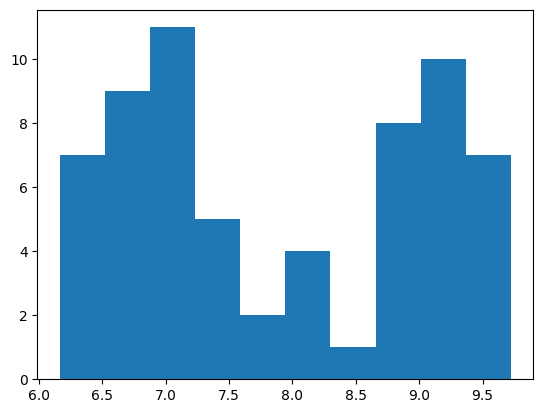

In [56]:
#let's plot it
import matplotlib.pyplot as plt
plt.hist(out[1]) #this is bimodal, but what if we just do it not to the batch but the whole thing

In [57]:
#do it to all the cts data for peaks and nonpeaks
peak_cts_all = np.log(1+peak_cts.sum(-1, keepdims=True))
nonpeak_cts_all = np.log(1+nonpeak_cts.sum(-1, keepdims=True))
print(peak_cts_all.shape, nonpeak_cts_all.shape)

(220311, 1) (220221, 1)


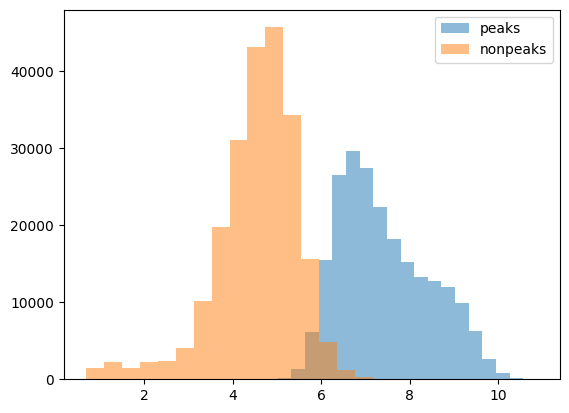

In [60]:
#let's do a hist with both and alpha of 0.5
plt.hist(peak_cts_all, alpha=0.5, bins=20)
plt.hist(nonpeak_cts_all, alpha=0.5, bins=20)
#and a legend
plt.legend(['peaks', 'nonpeaks'])
#counts are much higher in peak regions, that's crazy!!!!

In [62]:
#now owe will test the random jitter
def take_per_row(A, indx, num_elem):
    """
    Matrix A, indx is a vector for each row which specifies 
    slice beginning for that row. Each has width num_elem.
    """

    all_indx = indx[:,None] + np.arange(num_elem)
    return A[np.arange(all_indx.shape[0])[:,None], all_indx]


def random_crop(seqs, labels, seq_crop_width, label_crop_width, coords):
    """
    Takes sequences and corresponding counts labels. They should have the same
    #examples. The widths would correspond to inputlen and outputlen respectively,
    and any additional flanking width for jittering which should be the same
    for seqs and labels. Each example is cropped starting at a random offset. 

    seq_crop_width - label_crop_width should be equal to seqs width - labels width,
    essentially implying they should have the same flanking width.
    """

    assert(seqs.shape[1]>=seq_crop_width)
    assert(labels.shape[1]>=label_crop_width)
    assert(seqs.shape[1] - seq_crop_width == labels.shape[1] - label_crop_width)

    max_start = seqs.shape[1] - seq_crop_width # This should be the same for both input and output

    starts = np.random.choice(range(max_start+1), size=seqs.shape[0], replace=True)

    new_coords = coords.copy()
    new_coords[:,1] = new_coords[:,1].astype(int) - (seqs.shape[1]//2) + starts

    return take_per_row(seqs, starts, seq_crop_width), take_per_row(labels, starts, label_crop_width), new_coords

out = random_crop(peak_seqs, peak_cts, 2114, 1000, peak_coords) #has to be this where the amount cropped is like this!
print(out[0])
#if these are the inputs, we see that it starts between 0 and 1000

[[[1 0 0 0]
  [0 1 0 0]
  [1 0 0 0]
  ...
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]

 [[0 1 0 0]
  [0 1 0 0]
  [1 0 0 0]
  ...
  [1 0 0 0]
  [0 0 1 0]
  [1 0 0 0]]

 [[0 1 0 0]
  [0 0 0 1]
  [0 1 0 0]
  ...
  [0 0 0 1]
  [0 0 1 0]
  [0 0 1 0]]

 ...

 [[1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  ...
  [0 0 1 0]
  [0 1 0 0]
  [1 0 0 0]]

 [[1 0 0 0]
  [0 0 0 1]
  [0 0 1 0]
  ...
  [1 0 0 0]
  [1 0 0 0]
  [0 1 0 0]]

 [[0 1 0 0]
  [1 0 0 0]
  [1 0 0 0]
  ...
  [0 0 0 1]
  [0 0 0 1]
  [0 1 0 0]]]


In [63]:
out[0].shape #crops it to this size of 2114
#so what I think is happening is it aligns the middle to the middle

(220311, 2114, 4)

In [68]:
#let's test it with a known input and output to see what happens
data = np.array(range(0,3114))[None,:,None]
print(data.shape)
labels = np.array(range(0,2000))[None,:,None] #this is basically what we see!
out = random_crop(data, labels, 2114, 1000, peak_coords)
print(out[0])

(1, 3114, 1)
[[[ 756]
  [ 757]
  [ 758]
  ...
  [2867]
  [2868]
  [2869]]]


In [69]:
print(out[1]) #yeah so it seems to be aligning them in this way which is not good, why would 1:2000 be same as 1:1000??

[[[ 756]
  [ 757]
  [ 758]
  [ 759]
  [ 760]
  [ 761]
  [ 762]
  [ 763]
  [ 764]
  [ 765]
  [ 766]
  [ 767]
  [ 768]
  [ 769]
  [ 770]
  [ 771]
  [ 772]
  [ 773]
  [ 774]
  [ 775]
  [ 776]
  [ 777]
  [ 778]
  [ 779]
  [ 780]
  [ 781]
  [ 782]
  [ 783]
  [ 784]
  [ 785]
  [ 786]
  [ 787]
  [ 788]
  [ 789]
  [ 790]
  [ 791]
  [ 792]
  [ 793]
  [ 794]
  [ 795]
  [ 796]
  [ 797]
  [ 798]
  [ 799]
  [ 800]
  [ 801]
  [ 802]
  [ 803]
  [ 804]
  [ 805]
  [ 806]
  [ 807]
  [ 808]
  [ 809]
  [ 810]
  [ 811]
  [ 812]
  [ 813]
  [ 814]
  [ 815]
  [ 816]
  [ 817]
  [ 818]
  [ 819]
  [ 820]
  [ 821]
  [ 822]
  [ 823]
  [ 824]
  [ 825]
  [ 826]
  [ 827]
  [ 828]
  [ 829]
  [ 830]
  [ 831]
  [ 832]
  [ 833]
  [ 834]
  [ 835]
  [ 836]
  [ 837]
  [ 838]
  [ 839]
  [ 840]
  [ 841]
  [ 842]
  [ 843]
  [ 844]
  [ 845]
  [ 846]
  [ 847]
  [ 848]
  [ 849]
  [ 850]
  [ 851]
  [ 852]
  [ 853]
  [ 854]
  [ 855]
  [ 856]
  [ 857]
  [ 858]
  [ 859]
  [ 860]
  [ 861]
  [ 862]
  [ 863]
  [ 864]
  [ 865]
  [ 866]
 

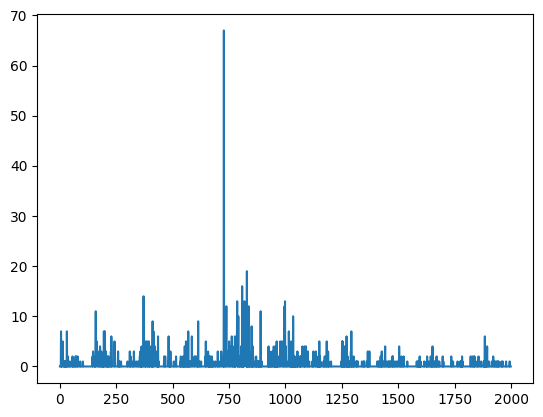

In [70]:
#let's plot one of the cts profiles
plt.plot(peak_cts[0])

In [ ]:
#potentially an issue is that the centers are not aligned, let's see how they defined it
#yeah... i don't get this at all??
#let's see how off the centers are

In [15]:
def take_per_row(A, indx, num_elem):
    """
    Matrix A, indx is a vector for each row which specifies 
    slice beginning for that row. Each has width num_elem.
    """

    all_indx = indx[:,None] + np.arange(num_elem)
    return A[np.arange(all_indx.shape[0])[:,None], all_indx]


def random_crop(seqs, labels, seq_crop_width, label_crop_width, coords):
    """
    Takes sequences and corresponding counts labels. They should have the same
    #examples. The widths would correspond to inputlen and outputlen respectively,
    and any additional flanking width for jittering which should be the same
    for seqs and labels. Each example is cropped starting at a random offset. 

    seq_crop_width - label_crop_width should be equal to seqs width - labels width,
    essentially implying they should have the same flanking width.
    """

    assert(seqs.shape[1]>=seq_crop_width)
    assert(labels.shape[1]>=label_crop_width)
    assert(seqs.shape[1] - seq_crop_width == labels.shape[1] - label_crop_width)

    max_start = seqs.shape[1] - seq_crop_width # This should be the same for both input and output

    starts = np.random.choice(range(max_start+1), size=seqs.shape[0], replace=True)

    new_coords = coords.copy()
    new_coords[:,1] = new_coords[:,1].astype(int) - (seqs.shape[1]//2) + starts

    return take_per_row(seqs, starts, seq_crop_width), take_per_row(labels, starts, label_crop_width), new_coords


In [12]:
import numpy as np
peak_seqs = np.array(range(-3114//2,3114//2))[None,:,None]
peak_cts = np.array(range(-1000,1000))[None,:,None]
#and now expand them so they repeat a bunch
peak_seqs = np.repeat(peak_seqs, 10000, axis=0)
peak_cts = np.repeat(peak_cts, 10000, axis=0)
print(peak_seqs.shape)
print(peak_cts.shape)
print(peak_seqs[0,1550:1560])
print(peak_seqs[0,0], peak_seqs[0,-1], peak_seqs[0,3114//2]) #that's the zero point or the center!!
# out = random_crop(peak_seqs, peak_cts, 2114, 1000, peak_coords) #has to be this where the amount cropped is like this!

(10000, 3114, 1)
(10000, 2000, 1)
[[-7]
 [-6]
 [-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]]
[-1557] [1556] [0]


In [17]:
#now let's run it through and see how off the centers are!
folder = '/data/leslie/sarthak/data/chrombpnet_test/saved_data/train/'
peak_coords = np.load(folder+'peak_coords.npy')
peak_coords = peak_coords[:10000]
out = random_crop(peak_seqs, peak_cts, 2114, 1000, peak_coords)
print(out)

(array([[[ -648],
        [ -647],
        [ -646],
        ...,
        [ 1463],
        [ 1464],
        [ 1465]],

       [[ -572],
        [ -571],
        [ -570],
        ...,
        [ 1539],
        [ 1540],
        [ 1541]],

       [[-1073],
        [-1072],
        [-1071],
        ...,
        [ 1038],
        [ 1039],
        [ 1040]],

       ...,

       [[-1550],
        [-1549],
        [-1548],
        ...,
        [  561],
        [  562],
        [  563]],

       [[ -849],
        [ -848],
        [ -847],
        ...,
        [ 1262],
        [ 1263],
        [ 1264]],

       [[ -670],
        [ -669],
        [ -668],
        ...,
        [ 1441],
        [ 1442],
        [ 1443]]]), array([[[ -91],
        [ -90],
        [ -89],
        ...,
        [ 906],
        [ 907],
        [ 908]],

       [[ -15],
        [ -14],
        [ -13],
        ...,
        [ 982],
        [ 983],
        [ 984]],

       [[-516],
        [-515],
        [-514],
        ...,


In [19]:
print(out[0].shape) #let's see some of the new center values
print(out[0][:10,2114//2])

(10000, 2114, 1)
[[ 409]
 [ 485]
 [ -16]
 [ 235]
 [ 365]
 [ 347]
 [  -2]
 [-289]
 [ -42]
 [ 237]]


(array([49., 46., 45., 48., 34., 54., 51., 38., 51., 50., 53., 47., 54.,
        67., 54., 49., 60., 46., 39., 53., 51., 46., 46., 63., 54., 51.,
        58., 44., 54., 49., 37., 51., 36., 59., 53., 48., 31., 47., 46.,
        62., 41., 47., 44., 49., 48., 44., 70., 59., 71., 36., 49., 46.,
        43., 56., 50., 49., 46., 53., 52., 42., 60., 55., 44., 50., 48.,
        51., 42., 35., 46., 59., 53., 57., 46., 56., 49., 49., 49., 42.,
        48., 52., 41., 53., 41., 54., 53., 46., 41., 45., 45., 52., 44.,
        68., 59., 51., 35., 40., 49., 56., 52., 54., 43., 57., 41., 47.,
        52., 49., 53., 49., 62., 46., 50., 54., 56., 54., 48., 46., 48.,
        54., 44., 55., 41., 48., 56., 55., 72., 46., 57., 61., 59., 60.,
        64., 45., 51., 58., 53., 55., 50., 50., 59., 40., 41., 37., 52.,
        44., 53., 53., 50., 47., 56., 66., 58., 49., 44., 53., 49., 43.,
        59., 42., 41., 57., 51., 43., 48., 45., 52., 46., 60., 52., 51.,
        44., 55., 56., 46., 58., 54., 49., 44., 62.

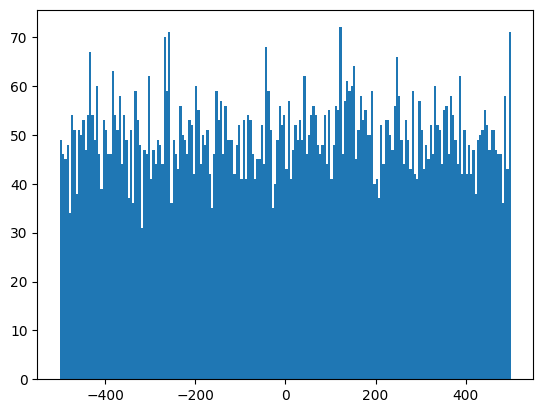

In [24]:
import matplotlib.pyplot as plt
#let's create a vector showing the values of the middle and plot it
plt.hist(out[0][:,2114//2], bins=200) #yeah it's off by up to 500 as we expected

(array([49., 46., 45., 48., 34., 54., 51., 38., 51., 50., 53., 47., 54.,
        67., 54., 49., 60., 46., 39., 53., 51., 46., 46., 63., 54., 51.,
        58., 44., 54., 49., 37., 51., 36., 59., 53., 48., 31., 47., 46.,
        62., 41., 47., 44., 49., 48., 44., 70., 59., 71., 36., 49., 46.,
        43., 56., 50., 49., 46., 53., 52., 42., 60., 55., 44., 50., 48.,
        51., 42., 35., 46., 59., 53., 57., 46., 56., 49., 49., 49., 42.,
        48., 52., 41., 53., 41., 54., 53., 46., 41., 45., 45., 52., 44.,
        68., 59., 51., 35., 40., 49., 56., 52., 54., 43., 57., 41., 47.,
        52., 49., 53., 49., 62., 46., 50., 54., 56., 54., 48., 46., 48.,
        54., 44., 55., 41., 48., 56., 55., 72., 46., 57., 61., 59., 60.,
        64., 45., 51., 58., 53., 55., 50., 50., 59., 40., 41., 37., 52.,
        44., 53., 53., 50., 47., 56., 66., 58., 49., 44., 53., 49., 43.,
        59., 42., 41., 57., 51., 43., 48., 45., 52., 46., 60., 52., 51.,
        44., 55., 56., 46., 58., 54., 49., 44., 62.

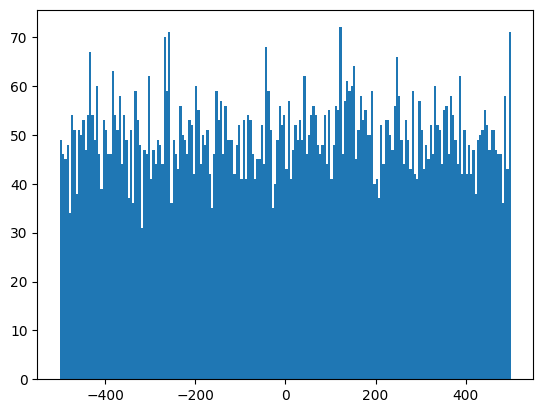

In [25]:
#same for the cts
plt.hist(out[1][:,1000//2], bins=200) #yeah it's off by up to 500 as we expected

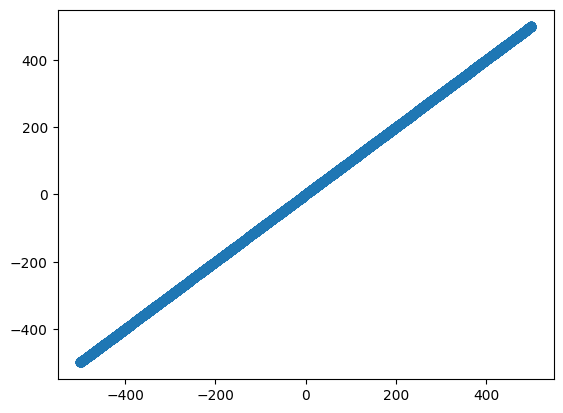

In [26]:
#now the real kicker, see how off they are
plt.scatter(out[0][:,2114//2], out[1][:,1000//2]) #oh, it's actually close???

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

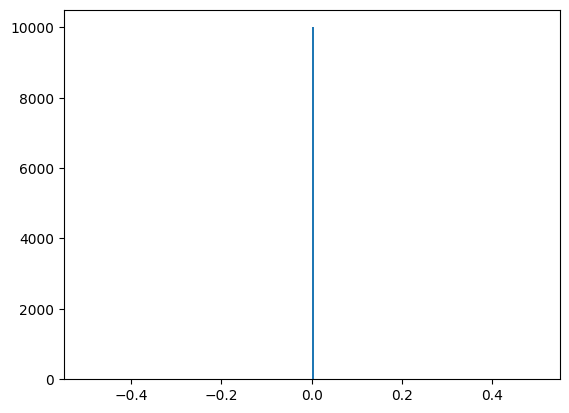

In [27]:
plt.hist(out[0][:,2114//2]-out[1][:,1000//2], bins=200) #wait, this is exact??!?!??!!!

In [32]:
#let's look at one example
seq = out[0][0]
cts = out[1][0]
print(seq.min(), seq.max(), cts.min(), cts.max())
# print(cts)
print(seq.min()+seq.max(), cts.min()+cts.max())

#the centers are  perfectly aligned???

-648 1465 -91 908
817 817


In [38]:
#this doesn't make sense unless I fundamentally misunderstand what's going on, maybe the math randomly works out for these lengths?
#Let's try having the input sequence be just a bit longer

peak_seqs = np.array(range(-3124//2,3114//2))[None,:,None]
peak_cts = np.array(range(-1005,1000))[None,:,None]
peak_seqs = np.repeat(peak_seqs, 10000, axis=0)
peak_cts = np.repeat(peak_cts, 10000, axis=0)
print(peak_seqs.shape, peak_cts.shape)
out = random_crop(peak_seqs, peak_cts, 2114, 1000, peak_coords)
seq = out[0][0]
cts = out[1][0]
print(seq.min(), seq.max(), cts.min(), cts.max())
# print(cts)
print(seq.min()+seq.max(), cts.min()+cts.max()) #still it's aligned?!?

(10000, 3119, 1) (10000, 2005, 1)
-1027 1086 -470 529
59 59


In [39]:
#final try where we have th einput be shorter
peak_seqs = np.array(range(-2114//2,3114//2))[None,:,None]
peak_cts = np.array(range(-500,1000))[None,:,None]
peak_seqs = np.repeat(peak_seqs, 10000, axis=0)
peak_cts = np.repeat(peak_cts, 10000, axis=0)
print(peak_seqs.shape, peak_cts.shape)
out = random_crop(peak_seqs, peak_cts, 2114, 1000, peak_coords)
seq = out[0][0]
cts = out[1][0]
print(seq.min(), seq.max(), cts.min(), cts.max())
# print(cts)
print(seq.min()+seq.max(), cts.min()+cts.max()) #still it's aligned?!?
#ok this somehow randomly works

(10000, 2614, 1) (10000, 1500, 1)
-983 1130 -426 573
147 147


In [42]:
#to verify we understand how this works
peak_seqs = np.array(range(3114))[None,:,None]
peak_cts = np.array(range(2000))[None,:,None]
peak_seqs = np.repeat(peak_seqs, 10000, axis=0)
peak_cts = np.repeat(peak_cts, 10000, axis=0)
print(peak_seqs.shape, peak_cts.shape)
out = random_crop(peak_seqs, peak_cts, 2114, 1000, peak_coords)
seq = out[0][0]
cts = out[1][0]
print(seq.min(), seq.max(), cts.min(), cts.max()) #right they now start at the same index...
print(seq.max()-seq.min(), cts.max()-cts.min()) #and they have the proper length while having the same starting index
#but then how are they still centered the same?

(10000, 3114, 1) (10000, 2000, 1)
383 2496 383 1382
2113 999


In [44]:
#let's make this easier by doing 3000 and 2000

peak_seqs = np.array(range(-1500,1500))[None,:,None]
peak_cts = np.array(range(-1000,1000))[None,:,None]
peak_seqs = np.repeat(peak_seqs, 10000, axis=0)
peak_cts = np.repeat(peak_cts, 10000, axis=0)
print(peak_seqs.shape, peak_cts.shape)
out = random_crop(peak_seqs, peak_cts, 2000, 1000, peak_coords)
seq = out[0][0]
cts = out[1][0]
print(seq.min(), seq.max(), cts.min(), cts.max()) #right they now start at the same index...
print(seq.max()+seq.min(), cts.max()+cts.min()) #and they have the proper length while having the same starting index
#but then how are they still centered the same?

(10000, 3000, 1) (10000, 2000, 1)
-866 1133 -366 633
267 267


In [46]:
#let's now manually sample and choose starting is 0
seq = peak_seqs[0]
cts = peak_cts[0]
start = 0
seq = seq[start:start+2000]
cts = cts[start:start+1000]
print(seq.min(), seq.max(), cts.min(), cts.max()) #right they now start at the same index...
print(seq.max()+seq.min(), cts.max()+cts.min()) #and they have the proper length while having the same starting index...
#ok they are somehow still centered the same

#dude we're so stupid, obviously the center is the same, the center is the center + start offset, and if they were centered the same, they still will be
#I'm so dumb, but we finally figured it out

-1500 499 -1000 -1
-1001 -1001


In [47]:
#finally let's just plot some more peaks
peak_cts = np.load(folder+'peak_cts.npy')
print(peak_cts.shape)

(220311, 2000)


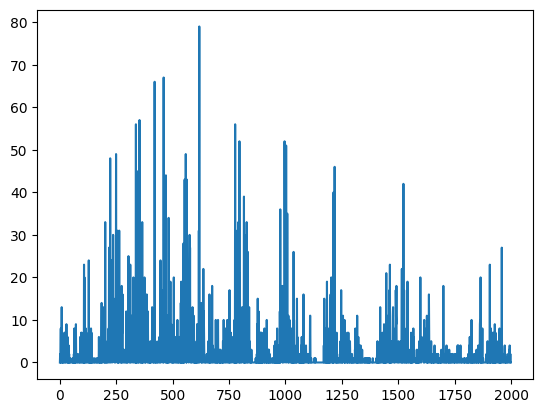

In [48]:
plt.plot(peak_cts[100])

In [49]:
#and when we do the log counts
a = np.log(1+peak_cts.sum(-1, keepdims=True))
print(a.shape)

(220311, 1)


(0.0, 50.0)

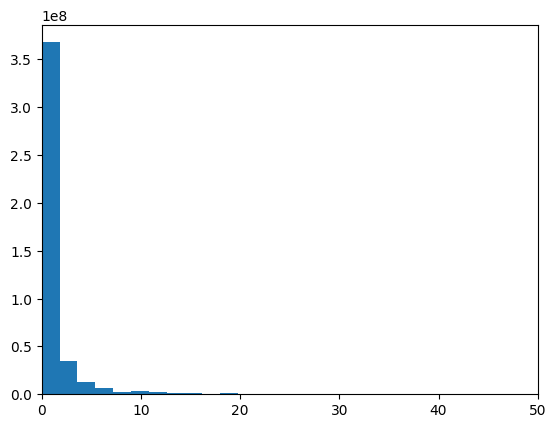

In [52]:
#let's just plot the distribution of the things
temp = peak_cts.flatten()
plt.hist(temp, bins=500)
#set xlim to 50
plt.xlim(0,50)

(220221, 1000)


(0.0, 50.0)

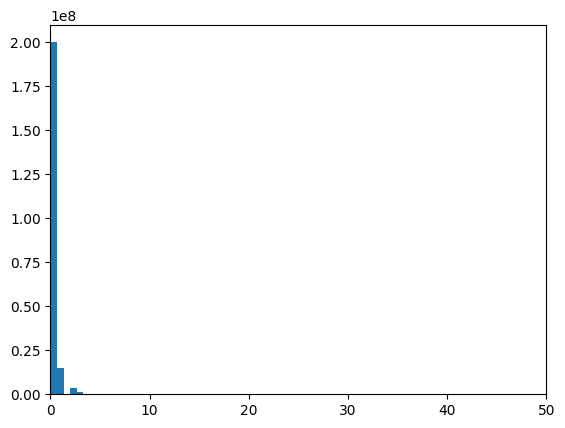

In [56]:
#and load the non peak cts regions
nonpeak_cts = np.load(folder+'nonpeak_cts.npy')
print(nonpeak_cts.shape)
#and same plot
temp = nonpeak_cts.flatten()
plt.hist(temp, bins=200)
#set xlim to 50
plt.xlim(0,50)

# finally produce some plots to show the differences between the models

In [ ]:
import numpy as np


In [1]:
#the first thing is we want to test the loss fucntion
#we have one implementation but likely better to use the jacob schreiber version of all these things

#the first thing we need to do is load in the dataloader and the bias model, we'll ignore the other hyena model right now

#a simple script to test loading the bias model into pytorch
#we have some scripts stored in bpnet lite
import sys
sys.path.append('/data/leslie/sarthak/chrombpnet')
from bpnetlite.bpnet import BPNet

#now let's try loading the model using the model method
model = BPNet.from_chrombpnet('/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5')
model
#and this works, just had to comment out those 2 lines lol!
#let's make a random size input
import torch
data = torch.rand(64,4,1000)*10
out = model(data)
print(out[0])
print(out[1])

tensor([], size=(64, 1, 0), grad_fn=<SliceBackward0>)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
 

In [5]:
#the first thing is we want to test the loss fucntion
#we have one implementation but likely better to use the jacob schreiber version of all these things

#the first thing we need to do is load in the dataloader and the bias model, we'll ignore the other hyena model right now

#a simple script to test loading the bias model into pytorch
#we have some scripts stored in bpnet lite
import sys
sys.path.append('/data/leslie/sarthak/chrombpnet')
from bpnetlite.bpnet import BPNet

#now let's try loading the model using the model method
model = BPNet.from_chrombpnet('/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5')
model
#and this works, just had to comment out those 2 lines lol!
#let's make a random size input
import torch
data = torch.rand(64,4,2114)*10
out = model(data)
print(len(out))
print(out[0].shape) #the profile
print(out[1].shape) #the counts
print(out)

2
torch.Size([64, 1, 1000])
torch.Size([64, 1])
(tensor([[[19.7039, -4.7962,  4.4985,  ..., 15.5877, 11.7697,  4.0288]],

        [[-7.7838, 13.0285,  3.9821,  ...,  1.6649,  3.5642, 21.0292]],

        [[ 6.6913, 10.7692,  6.2172,  ...,  3.5435, 15.5363,  6.0512]],

        ...,

        [[ 8.6928,  6.1781,  4.5914,  ..., 15.9411,  1.0150, 18.6154]],

        [[12.5325,  9.9352,  2.0833,  ..., 13.8965, -5.6194, 10.1420]],

        [[-5.5209,  5.7464, 18.2330,  ...,  6.0876, -3.0656, 15.3539]]],
       grad_fn=<SliceBackward0>), tensor([[17.7543],
        [17.9335],
        [18.1855],
        [17.9697],
        [17.8437],
        [18.1296],
        [17.8504],
        [18.2048],
        [17.8278],
        [17.7179],
        [18.0405],
        [18.4290],
        [17.7662],
        [17.9747],
        [18.0283],
        [18.0781],
        [17.8011],
        [17.9432],
        [17.9275],
        [17.7595],
        [18.0535],
        [17.7778],
        [17.9551],
        [17.9061],
        [

In [20]:
#oh i'm an idiot, the issue is that our input is not 1000 it's 1024 let's try that
data = torch.rand(64,4,1024)*10
out = model(data)
print(out)
#wait why does this have an issue now, it should be 800???
#it seems that the way it's defined, it just goes from that fconv to the number of layers, there's nothing else
data = torch.rand(64,4,1524)*10 #this does work...
out = model(data)
print(out)

(tensor([], size=(64, 1, 0), grad_fn=<SliceBackward0>), tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],

In [1]:
#hmmm, let's try to load the tensorflow model to compare...
#if it can load the data, that's good!


import argparse
import sys
sys.path.insert(0,'/data/leslie/sarthak/chrombpnet/')
# print(sys.path)
sys.path.append('/data/leslie/sarthak/chrombpnet/chrombpnet/')
#path of test args
#/data/leslie/sarthak/chrombpnet/chrombpnet/test_args.py
from test_args import main
sys.argv = [
    'test_args.py', 'pipeline',
    '-ibam', 'merged.bam',
    '-d', 'ATAC',
    '-g', 'hg38.fa',
    '-c', 'hg38.chrom.sizes',
    '-p', 'peaks_no_blacklist.bed',
    '-n', 'output_negatives.bed',
    '-fl', 'splits/fold_0.json',
    '-b', 'bias_model_1000/models/k562_bias.h5',
    '-o', 'chrombpnet_model/',
    '-il', '1024',
    '-ol', '800'
]
args = main()
#and now we can simulate our args

#now we modify args
import json
import os
if args.file_prefix:
    fpx = args.file_prefix+"_"
else:
    fpx = ""


#does use the proper parser that includes the new stuff!
#also need to specify il and ol for the model to figure it out
#that way when we load the modle knows the sizes
#also the crop is done to make it 800, has to do some level of cropping otherwise who knows

Namespace(cmd='pipeline', genome='hg38.fa', chrom_sizes='hg38.chrom.sizes', input_bam_file='merged.bam', input_fragment_file=None, input_tagalign_file=None, output_dir='chrombpnet_model/', data_type='ATAC', peaks='peaks_no_blacklist.bed', nonpeaks='output_negatives.bed', chr_fold_path='splits/fold_0.json', outlier_threshold=0.9999, ATAC_ref_path=None, DNASE_ref_path=None, num_samples=10000, inputlen=1024, outputlen=800, seed=1234, epochs=50, early_stop=5, learning_rate=0.001, trackables=['logcount_predictions_loss', 'loss', 'logits_profile_predictions_loss', 'val_logcount_predictions_loss', 'val_loss', 'val_logits_profile_predictions_loss'], architecture_from_file=None, file_prefix=None, html_prefix='./', bsort=False, tmpdir=None, no_st=False, skip_preprocessing=False, save_data=None, bias_model_path='bias_model_1000/models/k562_bias.h5', negative_sampling_ratio=0.1, filters=512, n_dilation_layers=8, max_jitter=500, batch_size=64)
False
None


In [2]:
# Shift bam and convert to bigwig
# import chrombpnet.helpers.preprocessing.reads_to_bigwig as reads_to_bigwig	
args.output_prefix = os.path.join(args.output_dir,"auxiliary/{}data".format(fpx))
args.plus_shift = None
args.minus_shift = None
args.bigwig = os.path.join(args.output_dir,"auxiliary/{}data_unstranded.bw".format(fpx))
args.output_prefix = os.path.join(args.output_dir,"evaluation/{}bw_shift_qc".format(fpx))
os.chdir('/data/leslie/sarthak/data/chrombpnet_test/')
folds = json.load(open(args.chr_fold_path))
assert(len(folds["valid"]) > 0) # validation list of chromosomes is empty
args.chr = folds["valid"][0]
args.pwm_width=24
folds
import copy
import chrombpnet.training.models.chrombpnet_with_bias_model as chrombpnet_with_bias_model
import chrombpnet.training.train as train
args_copy = copy.deepcopy(args)
if args_copy.architecture_from_file is None:
    args_copy.architecture_from_file = 	chrombpnet_with_bias_model.__file__
args_copy.peaks = os.path.join(args.output_dir,"auxiliary/{}filtered.peaks.bed".format(fpx))
args_copy.nonpeaks = os.path.join(args.output_dir,"auxiliary/{}filtered.nonpeaks.bed".format(fpx))
args_copy.output_prefix = os.path.join(args.output_dir,"models/{}chrombpnet".format(fpx))
args_copy.params = os.path.join(args.output_dir,"logs/{}chrombpnet_model_params.tsv".format(fpx))
args_copy #this is the official one that has all of the things specified!
args = args_copy
#but instead of directly calling train.main, we'll go through it to get to the source of our things!
import numpy as np
import chrombpnet.training.data_generators.initializers as initializers
parameters = train.get_model_param_dict(args)
print(parameters)
np.random.seed(args.seed)

# get model architecture to load
# model, architecture_module=train.get_model(args, parameters)

# initialize generators to load data
# train_generator = initializers.initialize_generators(args, "train", parameters, return_coords=False) #gets the peaks and takes forever to get the sequences
# valid_generator = initializers.initialize_generators(args, "valid", parameters, return_coords=False)
model, architecture_module=train.get_model(args, parameters) #this is killing it for some reason if we use the lt nodes...
#seems to be an issue if there are gpus but its inaccessible...

{'counts_loss_weight': '76.2', 'filters': '512', 'n_dil_layers': '8', 'bias_model_path': 'chrombpnet_model/models/bias_model_scaled.h5', 'inputlen': '2114', 'outputlen': '1000', 'max_jitter': '500', 'chr_fold_path': 'splits/fold_0.json', 'negative_sampling_ratio': '0.1'}


2024-06-12 17:52:16.399272: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 17:52:19.303510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43483 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-06-12 17:52:19.305995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43483 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-06-12 17:52:19.308583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

got the model


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 2114, 4)]    0           []                               
                                                                                                  
 model_wo_bias (Functional)     [(None, 1000),       6377986     ['sequence[0][0]']               
                                 (None, 1)]                                                       
                                                                                                  
 model (Functional)             [(None, 1000),       217730      ['sequence[0][0]']               
                                 (None, 1)]                                                       
                                                                                              

In [9]:
print(architecture_module) #this is just the module it comes from 
print(parameters)

<module '' from '/data/leslie/sarthak/chrombpnet/chrombpnet/training/models/chrombpnet_with_bias_model.py'>
{'counts_loss_weight': '76.2', 'filters': '512', 'n_dil_layers': '8', 'bias_model_path': 'chrombpnet_model/models/bias_model_scaled.h5', 'inputlen': '2114', 'outputlen': '1000', 'max_jitter': '500', 'chr_fold_path': 'splits/fold_0.json', 'negative_sampling_ratio': '0.1'}


In [ ]:
#oh, so it's in the parameters that we define it...
#where does args.params get defined?
#it continues to load the full chrombpnet model notjust the bias model
args.params = os.path.join(args.output_dir,"logs/{}chrombpnet_model_params.tsv".format(fpx))

# loading only the bias model

In [11]:
#let's copy the code form the bias model stuff, but it's actually quite simple
import chrombpnet.training.models.bpnet_model as bpnet_model
args.params = '/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/logs/k562_bias_model_params.tsv'
parameters = train.get_model_param_dict(args)
print(parameters)
np.random.seed(args.seed)
args.architecture_from_file = bpnet_model.__file__
model, architecture_module=train.get_model(args, parameters) #this is killing it for some reason if we use the lt nodes...


{'counts_loss_weight': '5.0', 'filters': '128', 'n_dil_layers': '4', 'inputlen': '1024', 'outputlen': '800', 'max_jitter': '0', 'chr_fold_path': 'splits/fold_0.json', 'negative_sampling_ratio': '1.0'}
params:
filters:128
n_dil_layers:4
conv1_kernel_size:21
profile_kernel_size:75
counts_loss_weight:5.0
got the model


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1024, 4)]    0           []                               
                                                                                                  
 bpnet_1st_conv (Conv1D)        (None, 1004, 128)    10880       ['sequence[0][0]']               
                                                                                                  
 bpnet_1conv (Conv1D)           (None, 1000, 128)    49280       ['bpnet_1st_conv[0][0]']         
                                                                                                  
 bpnet_1crop (Cropping1D)       (None, 1000, 128)    0           ['bpnet_1st_conv[0][0]']         
                                                                                            

In [14]:
#now let's see what the output is

#one key idea is that we can easily load the full model or the bias model depending on the parameters that are used
#this is where we need to consider that main path carefully and think about what we are loading
#then look at load_pytorch to see how we can extract just the bias from that

test_input = np.random.rand(64,4,1024).transpose(0,2,1)
out = model(test_input)
print(out[0].shape) #the profile
print(out[1].shape) #the counts

2024-06-12 18:02:43.583001: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-06-12 18:02:46.381994: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-06-12 18:02:46.529984: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-06-12 18:02:46.530039: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at /usr/local/cuda-11.0/bin/ptxas
2024-06-12 18:02:46.582705: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: /usr/local/cuda-11.0/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH 

(64, 800)
(64, 1)


In [ ]:
#right this is perfect! takes in the proper input and output sizes!
#I did indeed get it working, now we can give some test inputs to make sure it actually works!

In [15]:
#let's produce some random data as a numpy array and save it
import numpy as np
random_data = np.random.rand(64,4,1024)
np.save('/data/leslie/sarthak/data/chrombpnet_test/random_data.npy', random_data)

In [21]:
#now put this through our tf model
out = model(random_data.transpose(0,2,1))
print(out[0].shape) #the profile
print(out[1].shape) #the counts
print(out)
#and save it
# np.save('/data/leslie/sarthak/data/chrombpnet_test/random_data_out_tf.npy', out)

(64, 800)
(64, 1)
[<tf.Tensor: shape=(64, 800), dtype=float32, numpy=
array([[0.8808726 , 0.8013918 , 0.65745014, ..., 1.2373575 , 0.75250757,
        1.0490739 ],
       [1.2703887 , 0.8373803 , 1.2273008 , ..., 1.0881332 , 1.0199597 ,
        0.8520004 ],
       [1.0319129 , 0.95693713, 0.77966154, ..., 1.0668644 , 0.607666  ,
        0.95279163],
       ...,
       [0.935431  , 1.0768732 , 0.881536  , ..., 0.8223386 , 1.0135232 ,
        0.87718135],
       [0.76885194, 0.9540718 , 0.75318724, ..., 0.9133344 , 0.7917833 ,
        1.0093429 ],
       [0.8136067 , 0.9625963 , 0.942116  , ..., 0.6299992 , 0.7503516 ,
        0.743367  ]], dtype=float32)>, <tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[ 2.38812715e-03],
       [ 2.00940296e-03],
       [ 1.63612366e-02],
       [-2.85905972e-03],
       [ 2.41808593e-05],
       [ 6.11192733e-03],
       [ 6.31880388e-03],
       [ 7.07410276e-03],
       [-6.48975372e-03],
       [-9.37065855e-03],
       [-9.54266638e-04],
 

In [1]:
#now change env to a pytorch one and try again
import sys
sys.path.append('/data/leslie/sarthak/chrombpnet')
from bpnetlite.bpnet import BPNet

#now let's try loading the model using the model method
model_path = '/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5'
model = BPNet(128,4,1,0)
# model = model.from_chrombpnet(model_path)

KeyboardInterrupt: 

In [ ]:
import torch
model

BPNet(
  (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
  (irelu): ReLU()
  (rconvs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  )
  (rrelus): ModuleList(
    (0-3): 4 x ReLU()
  )
  (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
data = torch.rand(64,4,1024)*10
out = model(data)
print(out[0].shape)
#so this makes it 992...

#we now modified the class method to optinally select a

torch.Size([64, 1, 992])


In [ ]:
model = BPNet(128,4,1,0,trimming=(1024-800)//2) #this is the amount to trim it by else it trims it based on n_layers
data = torch.rand(64,4,1024)*10
out = model(data)
print(out[0].shape)

torch.Size([64, 1, 800])


In [2]:
#so we modified the class method let's do it once more!

import sys
sys.path.append('/data/leslie/sarthak/chrombpnet')
from bpnetlite.bpnet import BPNet

#now let's try loading the model using the model method
model_path = '/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5'
model = BPNet.from_chrombpnet(model_path,trimming=(1024-800)//2)

In [3]:
#test the output
import torch
data = torch.rand(64,4,1024)*10
out = model(data)
print(out[0].shape)

torch.Size([64, 1, 800])


In [7]:
import numpy as np
model.eval()
random_data = np.load('/data/leslie/sarthak/data/chrombpnet_test/random_data.npy')
out = model(torch.tensor(random_data, dtype=torch.float32))
print(out[0].shape)
print(out)

torch.Size([64, 1, 800])
(tensor([[[18.1972, 16.5076, 18.5163,  ..., 17.5866, 18.2075, 16.1460]],

        [[16.4211, 16.8045, 15.4146,  ..., 18.4047, 13.4632, 17.7552]],

        [[17.5493, 17.5314, 15.9911,  ..., 17.2461, 16.4586, 17.2044]],

        ...,

        [[16.2961, 19.4594, 17.5705,  ..., 16.5637, 16.1835, 16.0648]],

        [[15.7617, 16.5974, 15.8781,  ..., 17.3675, 16.0852, 16.2983]],

        [[18.4622, 17.9159, 17.3200,  ..., 18.8353, 17.8724, 16.3885]]],
       grad_fn=<SliceBackward0>), tensor([[0.3181],
        [0.3637],
        [0.5114],
        [0.7545],
        [0.5496],
        [0.5451],
        [0.4257],
        [0.4215],
        [0.4670],
        [0.4628],
        [0.2385],
        [0.4687],
        [0.7036],
        [0.6573],
        [0.2930],
        [0.4032],
        [0.3923],
        [0.3897],
        [0.4952],
        [0.4041],
        [0.4898],
        [0.5279],
        [0.6936],
        [0.5533],
        [0.8648],
        [0.4256],
        [0.3628],
  

In [8]:
#save out the data with savez
np.savez('/data/leslie/sarthak/data/chrombpnet_test/random_data_out.npz', profile=out[0].detach().numpy(), counts=out[1].detach().numpy())

In [8]:
print(model.n_layers)
print(model.n_filters) #both of these are correct...
print(model.trimming)
#the kernel size seems correct too...

4
128
112


In [4]:
#hmmm, seems the tf thing doesn't actually load the weights, let's find where weights are loaded
#hmmm, yes it should say got the model, it probably didn't because we were calling the chrombpnet model one but that one doesn't exist!!

#hmmm, let's try to load the tensorflow model to compare...
#if it can load the data, that's good!


import argparse
import copy
import sys
sys.path.insert(0,'/data/leslie/sarthak/chrombpnet/')
# print(sys.path)
sys.path.append('/data/leslie/sarthak/chrombpnet/chrombpnet/')
#path of test args
#/data/leslie/sarthak/chrombpnet/chrombpnet/test_args.py
from test_args import main
sys.argv = [
    'test_args.py', 'pipeline',
    '-ibam', '/data/leslie/sarthak/data/chrombpnet_test/merged.bam',
    '-d', 'ATAC',
    '-g', '/data/leslie/sarthak/data/chrombpnet_test/hg38.fa',
    '-c', '/data/leslie/sarthak/data/chrombpnet_test/hg38.chrom.sizes',
    '-p', '/data/leslie/sarthak/data/chrombpnet_test/peaks_no_blacklist.bed',
    '-n', '/data/leslie/sarthak/data/chrombpnet_test/output_negatives.bed',
    '-fl', '/data/leslie/sarthak/data/chrombpnet_test/splits/fold_0.json',
    '-b', '/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5',
    '-o', '/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model/',
    '-il', '1024',
    '-ol', '800'
]
args = main()
#and now we can simulate our args

#now we modify args
import json
import os
if args.file_prefix:
    fpx = args.file_prefix+"_"
else:
    fpx = ""

args.output_prefix = os.path.join(args.output_dir,"auxiliary/{}data".format(fpx))
args.plus_shift = None
args.minus_shift = None
args.bigwig = os.path.join(args.output_dir,"auxiliary/{}data_unstranded.bw".format(fpx))
args.output_prefix = os.path.join(args.output_dir,"evaluation/{}bw_shift_qc".format(fpx))
folds = json.load(open(args.chr_fold_path))
args.chr = folds["valid"][0]
args.pwm_width=24

import chrombpnet.training.predict as predict
args_copy = copy.deepcopy(args)
args_copy.output_prefix = os.path.join(args_copy.output_dir,"evaluation/bias")
args_copy.peaks = os.path.join(args.output_dir,"auxiliary/{}filtered.peaks.bed".format(fpx))
args_copy.model_h5 = args.bias_model_path
args_copy.nonpeaks = "None"
print(args_copy.model_h5)

metrics_dictionary = {"counts_metrics":{}, "profile_metrics":{}}

# get model architecture to load - can load .hdf5 and .weights/.arch
model=predict.load_model_wrapper(args_copy)
#/data/leslie/sarthak/data/chrombpnet_test/bias_model_1000/models/k562_bias.h5

Namespace(cmd='pipeline', genome='/data/leslie/sarthak/data/chrombpnet_test/hg38.fa', chrom_sizes='/data/leslie/sarthak/data/chrombpnet_test/hg38.chrom.sizes', input_bam_file='/data/leslie/sarthak/data/chrombpnet_test/merged.bam', input_fragment_file=None, input_tagalign_file=None, output_dir='/data/leslie/sarthak/data/chrombpnet_test/chrombpnet_model/', data_type='ATAC', peaks='/data/leslie/sarthak/data/chrombpnet_test/peaks_no_blacklist.bed', nonpeaks='/data/leslie/sarthak/data/chrombpnet_test/output_negatives.bed', chr_fold_path='/data/leslie/sarthak/data/chrombpnet_test/splits/fold_0.json', outlier_threshold=0.9999, ATAC_ref_path=None, DNASE_ref_path=None, num_samples=10000, inputlen=1024, outputlen=800, seed=1234, epochs=50, early_stop=5, learning_rate=0.001, trackables=['logcount_predictions_loss', 'loss', 'logits_profile_predictions_loss', 'val_logcount_predictions_loss', 'val_loss', 'val_logits_profile_predictions_loss'], architecture_from_file=None, file_prefix=None, html_pref

2024-06-12 18:58:37.631210: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 18:58:42.728360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43483 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-06-12 18:58:42.730953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43483 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-06-12 18:58:42.733069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/

got the model


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1024, 4)]    0           []                               
                                                                                                  
 bpnet_1st_conv (Conv1D)        (None, 1004, 128)    10880       ['sequence[0][0]']               
                                                                                                  
 bpnet_1conv (Conv1D)           (None, 1000, 128)    49280       ['bpnet_1st_conv[0][0]']         
                                                                                                  
 bpnet_1crop (Cropping1D)       (None, 1000, 128)    0           ['bpnet_1st_conv[0][0]']         
                                                                                              

In [6]:
#now load the numpy data
import numpy as np
random_data = np.load('/data/leslie/sarthak/data/chrombpnet_test/random_data.npy')
out = model.predict(random_data.transpose(0,2,1)) #we used .predict, so that should be correct?...
print(out[0].shape)
print(out)

2024-06-12 18:59:33.518541: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8907
2024-06-12 18:59:35.949113: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-06-12 18:59:36.059249: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-06-12 18:59:36.059297: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at /usr/local/cuda-11.0/bin/ptxas
2024-06-12 18:59:36.059526: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: /usr/local/cuda-11.0/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH 

(64, 800)
[array([[18.196798, 16.507322, 18.515823, ..., 17.58556 , 18.207127,
        16.145851],
       [16.421154, 16.80496 , 15.415009, ..., 18.405018, 13.463007,
        17.755552],
       [17.548872, 17.531399, 15.990284, ..., 17.246464, 16.459332,
        17.20493 ],
       ...,
       [16.295742, 19.459198, 17.570374, ..., 16.563522, 16.183237,
        16.064318],
       [15.76068 , 16.596828, 15.877914, ..., 17.367533, 16.085135,
        16.298552],
       [18.461845, 17.91561 , 17.319199, ..., 18.835732, 17.872557,
        16.388456]], dtype=float32), array([[0.34984246],
       [0.3525459 ],
       [0.5043141 ],
       [0.7030291 ],
       [0.57013   ],
       [0.5940352 ],
       [0.4291471 ],
       [0.45199585],
       [0.48480594],
       [0.45125434],
       [0.25628242],
       [0.43266168],
       [0.67358077],
       [0.66231596],
       [0.25336158],
       [0.3737521 ],
       [0.38447112],
       [0.45783415],
       [0.5205494 ],
       [0.40876624],
       [0.47

In [7]:
#let's save out these results using np.savez
np.savez('/data/leslie/sarthak/data/chrombpnet_test/random_data_out_tf.npz', profile=out[0], counts=out[1])

In [2]:
#and now plot it
#first load the tf data
import numpy as np
data_tf = np.load('/data/leslie/sarthak/data/chrombpnet_test/random_data_out_tf.npz')
profile_tf = data_tf['profile']
counts_tf = data_tf['counts']
#and the pytorch data
data_pt = np.load('/data/leslie/sarthak/data/chrombpnet_test/random_data_out.npz')
profile_pt = data_pt['profile']
counts_pt = data_pt['counts']
import matplotlib.pyplot as plt
import seaborn as sns

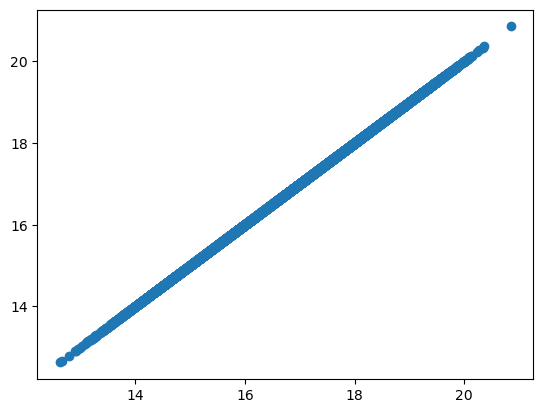

In [3]:
plt.scatter(profile_tf.flatten(), profile_pt.flatten())

Text(0.5, 1.0, 'Counts difference of bias model')

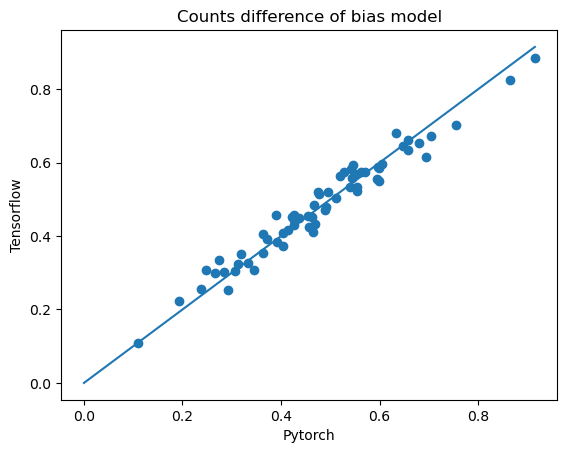

In [7]:
plt.scatter(counts_pt, counts_tf)
#and the 1,1 line
mymax = max(counts_pt.max(), counts_tf.max())
plt.plot([0,mymax],[0,mymax])
plt.xlabel('Pytorch')
plt.ylabel('Tensorflow')
plt.title('Counts difference of bias model')

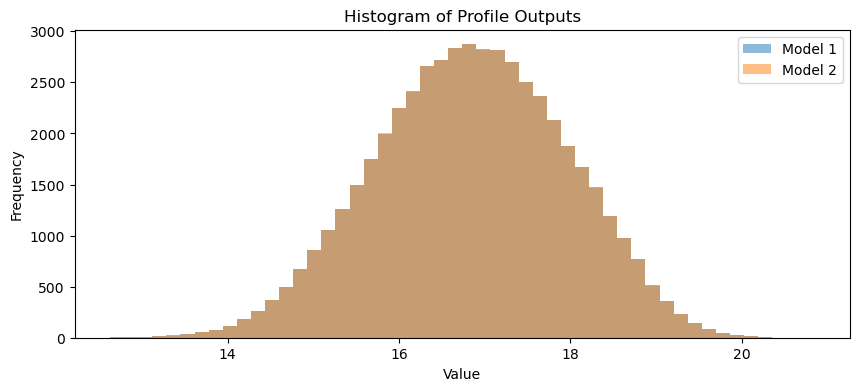

In [8]:
import numpy as np

# Flatten the profiles for histogram comparison
flat_profile1 = profile_tf.flatten()
flat_profile2 = profile_pt.flatten()

plt.figure(figsize=(10, 4))
plt.hist(flat_profile1, bins=50, alpha=0.5, label='Model 1')
plt.hist(flat_profile2, bins=50, alpha=0.5, label='Model 2')
plt.title('Histogram of Profile Outputs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Percentage change of profile outputs')

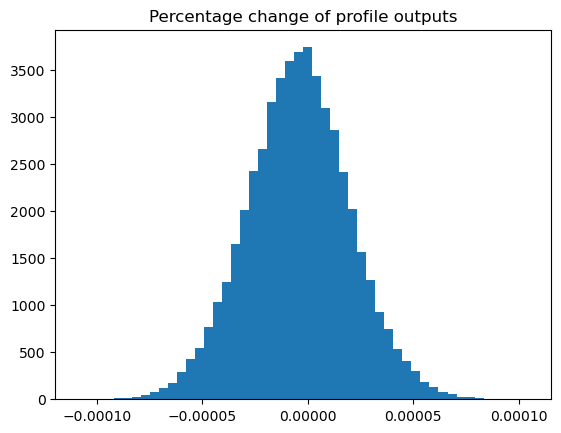

In [9]:
#plot the percentage change elementwise
plt.hist((profile_tf.flatten()-profile_pt.flatten())/profile_tf.flatten(), bins=50)
plt.title('Percentage change of profile outputs')

Text(0.5, 1.0, 'Percentage change of counts outputs')

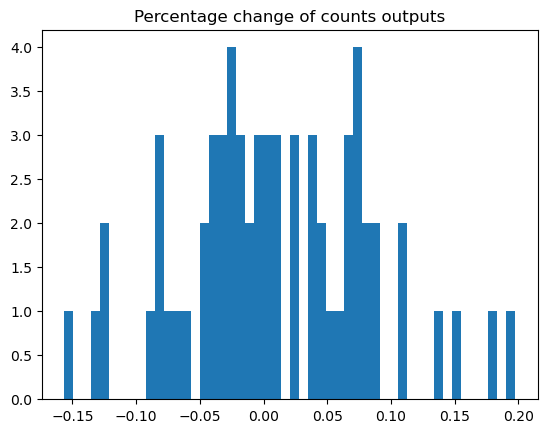

In [10]:
#and percentage change of counts
plt.hist((counts_tf.flatten()-counts_pt.flatten())/counts_tf.flatten(), bins=50)
plt.title('Percentage change of counts outputs')